<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Part 3 : Modelling Neural Networks

In [19]:
import requests
import re
import pickle
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [20]:
#importing the files from the previous notebook 

with open('./datasets/Z_train.pickle','rb') as read_file:
    Z_train = pickle.load(read_file)

with open('./datasets/y_train.pickle','rb') as read_file:
    y_train = pickle.load(read_file)

with open('./datasets/Z_test.pickle','rb') as read_file:
    Z_test = pickle.load(read_file)

with open('./datasets/y_test.pickle','rb') as read_file:
    y_test = pickle.load(read_file)


print(y_train.shape,Z_train.shape)

(15822,) (15822, 232)


In [21]:
#estimeate number of neurons
#The number of hidden neurons should be between the size of the input layer and the size of the output layer.
#The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
#The number of hidden neurons should be less than twice the size of the input layer.
alpha=0.5  #arbitary number
feature = len(Z_train[0])
sample = len(Z_train)
output = 1
num_n = sample/(alpha*(feature+output))

print(feature, sample, output)

print(f'The estimated nerons number is {num_n}')
print(f'Hence, let set the neurons in hidden layer to 100')

232 15822 1
The estimated nerons number is 135.81115879828326
Hence, let set the neurons in hidden layer to 100


In [22]:
## class weight imbalance refer to https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
## https://www.tensorflow.org/api_docs/python/tf/keras/utils/class_weight
neg,pos = np.bincount(y_train)
initial_bias = np.log([pos/neg])
print(initial_bias) 

#no imbalance data after SMOTE , bias = 0

[0.]


In [23]:
#check if any weight need to be included

weight_for_0 = (1 / neg) * ((neg+pos) / 2.0)
weight_for_1 = (1 / pos) * ((neg+pos)/ 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

#well balanced! class weight = 1

Weight for class 0: 1.00
Weight for class 1: 1.00


In [24]:
#create function for simple neural network structure

def make_model(metrics = ['accuracy'], output_bias = None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = Sequential([
        Dense(100, activation='relu', input_shape=(feature,)),
        Dropout(0.35),
        Dense(100, activation='relu'),
        Dropout(0.35),
        Dense(1, activation='sigmoid', bias_initializer=output_bias),
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=metrics)
    return model


In [25]:
#early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto')
checkpoint = ModelCheckpoint(filepath='./datasets/NN_model.h5', monitor='val_loss', save_best_only=True)

In [26]:
model = make_model(output_bias=initial_bias)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               23300     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 33,501
Trainable params: 33,501
Non-trainable params: 0
_________________________________________________________________


In [27]:
#for early stopping approach
model1 = make_model(output_bias=initial_bias) 
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 100)               23300     
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 100)               10100     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 33,501
Trainable params: 33,501
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(Z_train, y_train, epochs=20, batch_size=512, validation_data=(Z_test, y_test),class_weight=class_weight)

Epoch 1/20
31/31 [==============================] - 1s 15ms/step - loss: 0.6251 - accuracy: 0.6531 - val_loss: 0.5498 - val_accuracy: 0.7257
Epoch 2/20
31/31 [==============================] - 0s 10ms/step - loss: 0.4802 - accuracy: 0.7751 - val_loss: 0.4518 - val_accuracy: 0.7817
Epoch 3/20
31/31 [==============================] - 0s 11ms/step - loss: 0.4205 - accuracy: 0.8081 - val_loss: 0.4079 - val_accuracy: 0.7918
Epoch 4/20
31/31 [==============================] - 0s 10ms/step - loss: 0.3826 - accuracy: 0.8312 - val_loss: 0.4530 - val_accuracy: 0.7741
Epoch 5/20
31/31 [==============================] - 0s 11ms/step - loss: 0.3466 - accuracy: 0.8514 - val_loss: 0.4047 - val_accuracy: 0.7999
Epoch 6/20
31/31 [==============================] - 0s 11ms/step - loss: 0.3184 - accuracy: 0.8674 - val_loss: 0.3604 - val_accuracy: 0.8191
Epoch 7/20
31/31 [==============================] - 0s 11ms/step - loss: 0.2952 - accuracy: 0.8793 - val_loss: 0.3470 - val_accuracy: 0.8286
Epoch 8/20
31

In [29]:
history1 = model1.fit(Z_train, y_train, epochs=20, batch_size=512, validation_data=(Z_test, y_test),callbacks=[early_stop,checkpoint],class_weight=class_weight)

Epoch 1/20
31/31 [==============================] - 1s 17ms/step - loss: 0.6113 - accuracy: 0.6847 - val_loss: 0.5032 - val_accuracy: 0.7659
Epoch 2/20
31/31 [==============================] - 0s 12ms/step - loss: 0.4783 - accuracy: 0.7837 - val_loss: 0.4237 - val_accuracy: 0.7970
Epoch 3/20
31/31 [==============================] - 0s 12ms/step - loss: 0.4192 - accuracy: 0.8105 - val_loss: 0.3783 - val_accuracy: 0.8095
Epoch 4/20
31/31 [==============================] - 0s 13ms/step - loss: 0.3695 - accuracy: 0.8410 - val_loss: 0.3752 - val_accuracy: 0.8100
Epoch 5/20
31/31 [==============================] - 0s 12ms/step - loss: 0.3306 - accuracy: 0.8592 - val_loss: 0.3371 - val_accuracy: 0.8325
Epoch 6/20
31/31 [==============================] - 0s 11ms/step - loss: 0.2929 - accuracy: 0.8802 - val_loss: 0.3750 - val_accuracy: 0.8219
Epoch 7/20
31/31 [==============================] - 0s 12ms/step - loss: 0.2653 - accuracy: 0.8964 - val_loss: 0.3192 - val_accuracy: 0.8545
Epoch 8/20
31

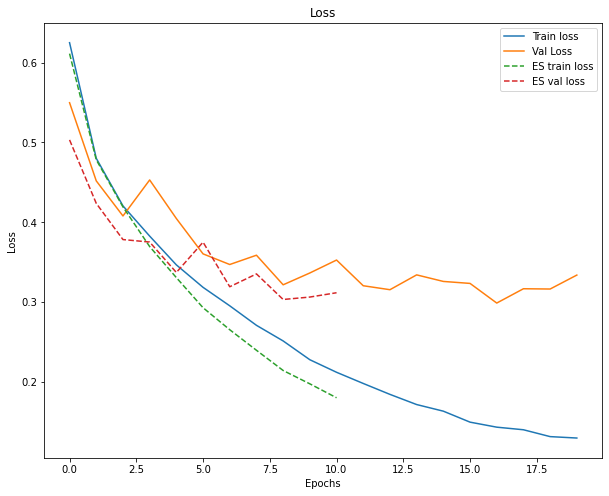

In [30]:
plt.figure(figsize=(10, 8))

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.plot(history1.history['loss'], label='ES train loss',linestyle='--')
plt.plot(history1.history['val_loss'], label='ES val loss',linestyle='--')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend();

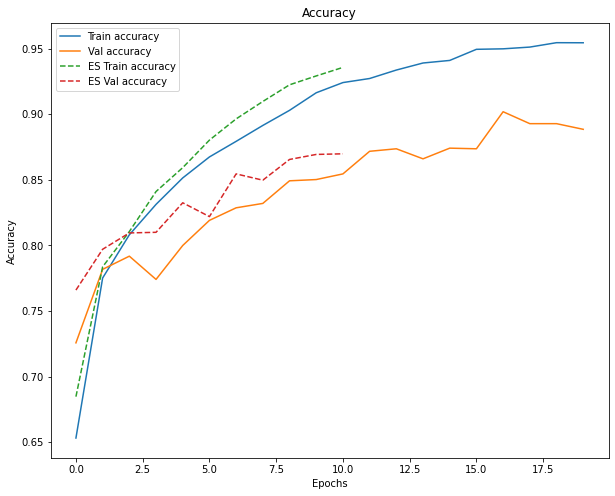

In [31]:
plt.figure(figsize=(10, 8))

plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.plot(history1.history['accuracy'], label='ES Train accuracy',linestyle='--')
plt.plot(history1.history['val_accuracy'], label='ES Val accuracy',linestyle='--')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

5/5 [==============================] - 0s 5ms/step
[1.69803984e-02 1.56519643e-04 9.30122375e-01 ... 1.05101235e-01
 2.27856869e-03 3.93281970e-03]
(2089, 1)


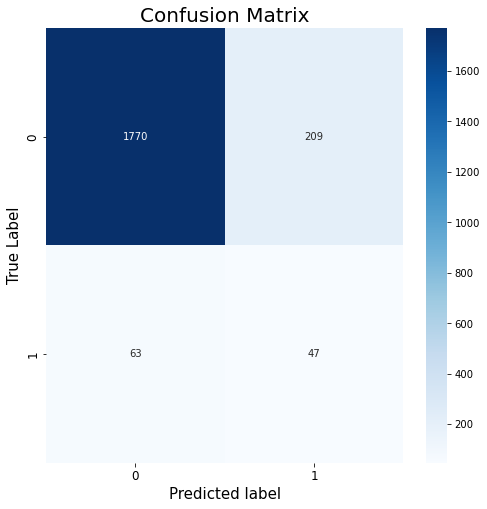

In [32]:
# Computing metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc,precision_recall_curve


y_pred_prob = model1.predict(Z_test, batch_size=512)
print(y_pred_prob.squeeze())
print(y_pred_prob.shape)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

fig,ax = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',cmap = 'Blues')
plt.title('Confusion Matrix',fontsize=20)
ax.set_xlabel('Predicted label',fontsize=15)
ax.set_ylabel('True Label',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.show()

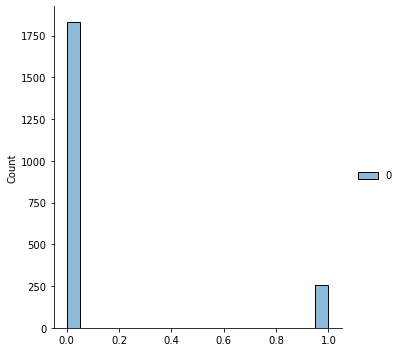

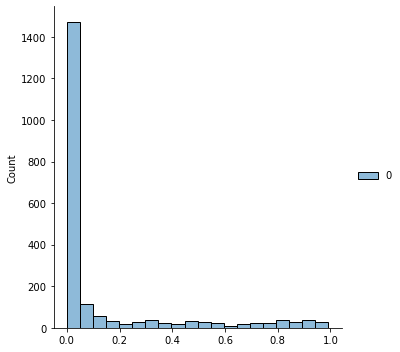

In [33]:
sns.displot(y_pred_prob>0.5, kde=False, rug=False, bins=20)
sns.displot(y_pred_prob, kde=False, rug=False, bins=20)

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93      1979
           1       0.18      0.43      0.26       110

    accuracy                           0.87      2089
   macro avg       0.57      0.66      0.59      2089
weighted avg       0.92      0.87      0.89      2089



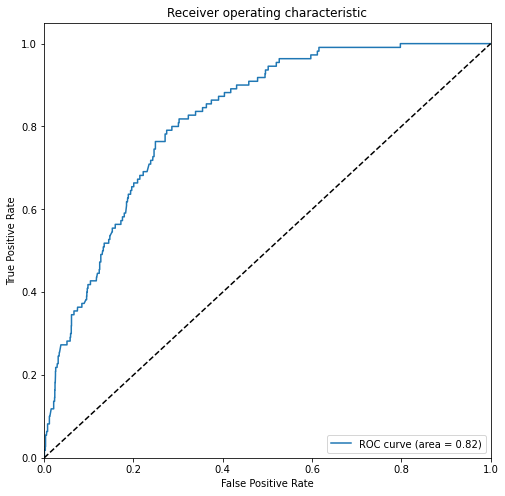

In [35]:
auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


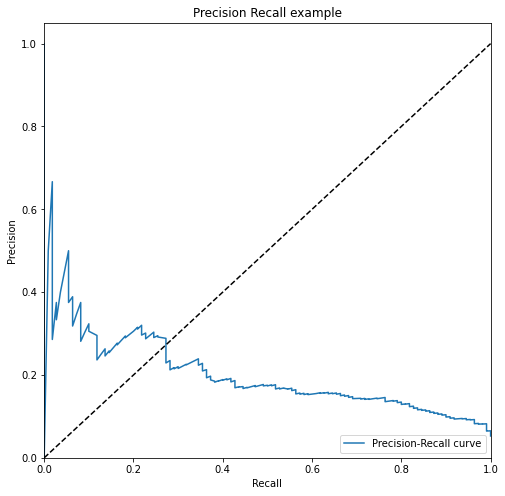

In [36]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 8))
plt.plot(recall,precision, label='Precision-Recall curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall example')
plt.legend(loc="lower right")
plt.show()
